In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os,sys
from datetime import datetime
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

### Read in information about the SAM index and EOF (based on u) 

In [2]:
ds_sam = xr.open_dataset("./Eddyfeedback_results/ERA5_1980_2023_SAMindex_u_S20.nc")


In [3]:
ds_sam

<xarray.Dataset>
Dimensions:   (time: 16071, lat: 249)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
  * lat       (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
Data variables:
    u_sam     (time, lat) float64 ...
    SAMindex  (time) float64 ...
    SAMeof    (lat) float64 ...

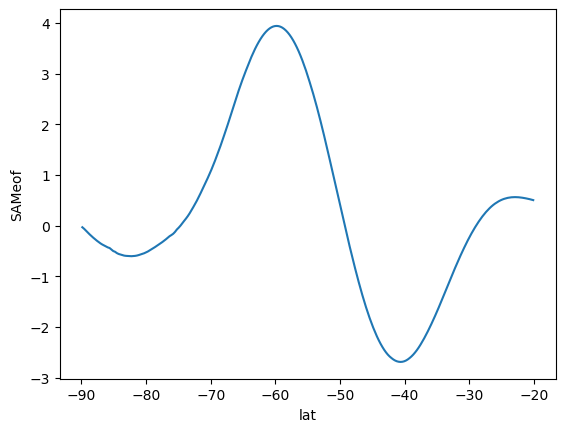

In [4]:
ds_sam['SAMeof'].plot()

### Read in information about m (eddy forcing of the SAM) and [u bar]_s

In [5]:
indir='/work/bk1377/b382037/WP7/Eddyfeedbackstrength/' 

ds = xr.open_dataset(''+indir+'ERA5_SAMsfcwindstress_1980_2023.nc')


In [6]:
ds

<xarray.Dataset>
Dimensions:          (valid_time: 16071)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 1980-01-01T11:30:00 ... 2023...
Data variables:
    uwindstress_sam  (valid_time) float64 ...

In [7]:
ds['time'] = ds_sam['time']

In [8]:
ds

<xarray.Dataset>
Dimensions:          (valid_time: 16071, time: 16071)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 1980-01-01T11:30:00 ... 2023...
  * time             (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
Data variables:
    uwindstress_sam  (valid_time) float64 ...

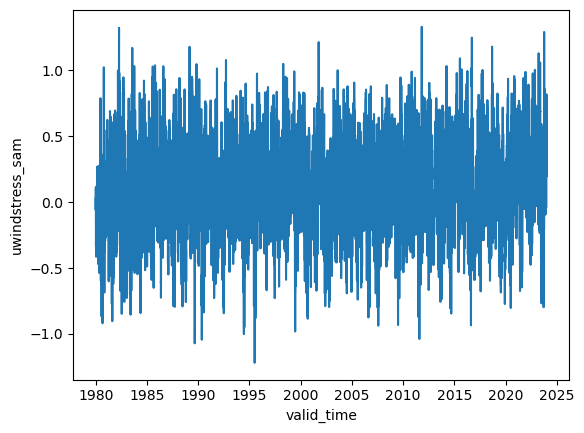

In [9]:
ds['uwindstress_sam'].plot()

In [10]:
indir='/work/bk1377/b382037/WP7/Eddyfeedbackstrength/new/' 

ds_u1D = xr.open_mfdataset(''+indir+'ERA5_SAMeddyforcingstrength_*_S20_new.nc', concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')
u1D   = ds_u1D['u1D'].to_numpy()

### Lagged linear regression onto the SAM index...
such that for a lag l,


  m(t+l)~ beta_m(l)PC(t)


u1D(t+l)~ beta_u(l)PC(t)

In [11]:
fricm = ds['uwindstress_sam'].to_numpy()*-1/1.225/8432 

In [12]:
nt = fricm.shape[0]

In [13]:
samindex=ds_sam['SAMindex'].isel(time=slice(30,nt-31))

In [14]:
print(fricm)

[-2.41442896e-06  5.90241753e-06  7.35694297e-07 ... -2.63173294e-05
 -2.38160313e-05 -1.92098102e-05]


In [15]:
print(nt, nt-31)

16071 16040


In [16]:
print(ds.coords['time'].isel(time=slice(30,nt-31)).shape)

(16010,)


In [17]:
lags_size = np.arange(-30,31,1)
print(lags_size.shape)

(61,)


In [18]:
coords_time= {'time':ds.coords['time'].isel(time=slice(30,nt-31)),'lags':np.arange(-30,31,1)}

flag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)
ulag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)

for i in range(0+30, nt-31):  # Adjust indices to account for slicing
       # Extract the 60-day window around the current day   
       window_data_u = u1D[i-30:i+31]  
       window_data_f = fricm[i-30:i+31]
       ulag_window.isel(time=i-30).values[:]  = window_data_u        
       flag_window.isel(time=i-30).values[:]  = window_data_f

### For Annual mean

In [19]:
from scipy.stats import linregress

ANNslope_f = np.zeros((61))
ANNslope_u = np.zeros((61))
for lag in range (0,61):
    ANNslope_u[lag], _, _, _, _ = linregress(samindex.to_numpy(), ulag_window[lag,:].to_numpy())
    ANNslope_f[lag], _, _, _, _ = linregress(samindex.to_numpy(), flag_window[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)

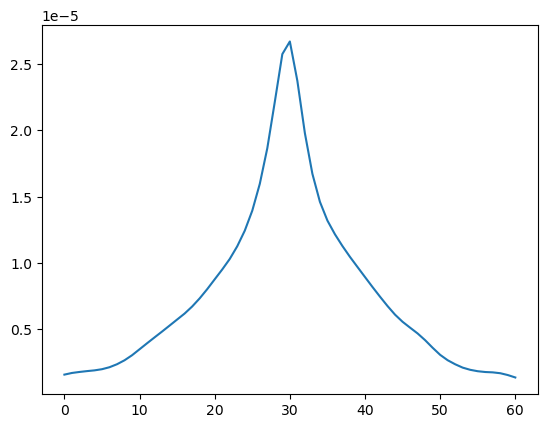

In [20]:
import matplotlib.pyplot as plt

plt.plot(ANNslope_f*-1)

### For NDJ

In [21]:
NDJ_flag = flag_window.sel(time=flag_window.time.dt.month.isin([11, 12, 1]))
NDJ_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([11, 12, 1]))

In [22]:
NDJ_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([11, 12, 1]))

In [23]:
NDJslope_f = np.zeros((61))
NDJslope_u = np.zeros((61))
for lag in range (0,61):
    NDJslope_u[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_ulag[lag,:].to_numpy())
    NDJslope_f[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_flag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)

### For FMA

In [24]:
FMA_flag = flag_window.sel(time=flag_window.time.dt.month.isin([2, 3, 4]))
FMA_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([2, 3, 4]))
FMA_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([2, 3, 4]))

In [25]:
FMAslope_f = np.zeros((61))
FMAslope_u = np.zeros((61))
for lag in range (0,61):
    FMAslope_u[lag], _, _, _, _ = linregress(FMA_SAMindex.to_numpy(), FMA_ulag[lag,:].to_numpy())
    FMAslope_f[lag], _, _, _, _ = linregress(FMA_SAMindex.to_numpy(), FMA_flag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [26]:
np.savetxt('ERA5_1980_2023_ANNslope_frescaled.out', ANNslope_f*86400, delimiter=',')
np.savetxt('ERA5_1980_2023_NDJslope_frescaled.out', NDJslope_f*86400, delimiter=',')
np.savetxt('ERA5_1980_2023_FMAslope_frescaled.out', FMAslope_f*86400, delimiter=',')

In [27]:
np.savetxt('ERA5_1980_2023_ANNslope_ftimescale.out', ANNslope_u/ANNslope_f/86400, delimiter=',')
np.savetxt('ERA5_1980_2023_NDJslope_ftimescale.out', NDJslope_u/NDJslope_f/86400, delimiter=',')
np.savetxt('ERA5_1980_2023_FMAslope_ftimescale.out', FMAslope_u/FMAslope_f/86400, delimiter=',')

In [28]:
np.savetxt('ERA5_1980_2023_ANNslope_u.out', ANNslope_u, delimiter=',')
np.savetxt('ERA5_1980_2023_NDJslope_u.out', NDJslope_u, delimiter=',')
np.savetxt('ERA5_1980_2023_FMAslope_u.out', FMAslope_u, delimiter=',')